In [62]:
from math import sqrt, ceil
from os import walk

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

def distance(x, y):
    return sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)

def show_err(test_data, model_data):
    print(f'ste: {np.sqrt(((model_data - test_data)**2).mean()):.3f} dBm')
    # show_hist(test_data - model_data)
    plt.figure(figsize = (7,4))
    plt.hist(test_data - model_data, np.arange(-40, 40, 1), density=True)
    plt.xlabel('Error (dBm)',size=12)
    plt.ylabel('Occurence proportion',size=12)
    plt.title('Error Distribution',size=18)

def stats(data):
    if not len(data):
        print('(stats empty)')
        return
    stat_k = 'mean', 'std', 'min', 'q25', 'mid', 'q75', 'max'
    stat_v = np.mean(data), np.std(data), np.min(data), np.quantile(data, 0.25), np.median(data), np.quantile(data, 0.75), np.max(data)
    print('\t'.join(stat_k))
    print('\t'.join(f'{v:.2f}' for v in stat_v))

def show_hist(data, info=''):
    data = data[~np.isnan(data)]
    bins = np.arange(int(data.min()), ceil(data.max()))
    print(f'{stats(data)} {info}')
    plt.figure(figsize=(4.4, 2.7))
    plt.hist(data, bins=bins, density=True)


### Regression

r_0 = -59.899531966002314
N = 0.4478971388640126
ste: 8.546 dBm


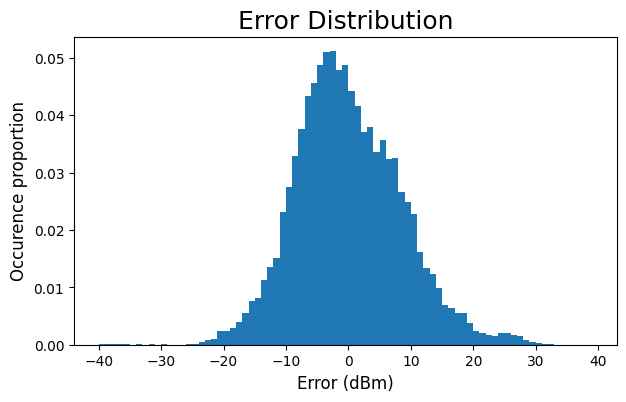

In [63]:
point_data = []

for node, sub, files in walk('../data'):
    if sub: continue
    for f in files:
        if f.startswith('point') and f.endswith('.csv'):
            data = pd.read_csv(f'{node}/{f}')
            gt = eval(open(f'{node}/{f.rstrip(".csv")}_gt.txt').read())
            beacons = pd.read_csv(f'{node}/beacons.csv').set_index('anchor')
            data['dist'] = data[data.anchor.isin(beacons.index)].apply(lambda row:distance(gt, beacons.loc[row.anchor]), axis=1)
            point_data.append(data.dropna())

point_data = pd.concat(point_data)
r = point_data.rssi
d = point_data.dist
model = np.polyfit(np.log(d), r, 1)
print(f'r_0 = {model[1]}')
print(f'N = {-model[0]/10}')
show_err(r, np.polyval(model, np.log(d)))

### Simulation of the cubic function

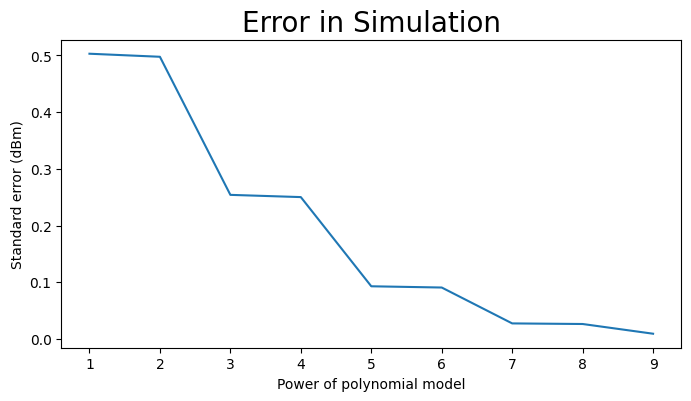

In [64]:
r_range = np.arange(-80, -39)
r_mean = np.arange(-80, -39, 0.05)

r_std = np.sqrt(10)
real_means = np.empty_like(r_mean)
for idx, mu in enumerate(r_mean):
    p = np.exp(-((r_range - mu)/r_std)**2 / 2)
    real_mean = (r_range * p).sum() / p.sum()
    p = p * 100 / p.sum()
    real_means[idx] = real_mean
n_range = np.arange(1,10)
errs = np.empty(9)
for n in n_range:
    err = np.sqrt(((np.polyval(np.polyfit(real_means, r_mean, n), real_means) - r_mean)**2).mean())
    #err = (np.abs(np.polyval(np.polyfit(real_means, r_mean, n), real_means) - r_mean)).mean
    errs[n-n_range[0]] = err

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(n_range, errs)
ax.set_xlabel('Power of polynomial model')
ax.set_ylabel('Standard error (dBm)')
ax.set_title('Error in Simulation', size=20); 

gamma_3 = 0.00044820869286716465
gamma_2 = 0.08102773016506967
gamma_1 = 5.8301051259798164
gamma_0 = 94.89508990821473
ste: 7.953 dBm


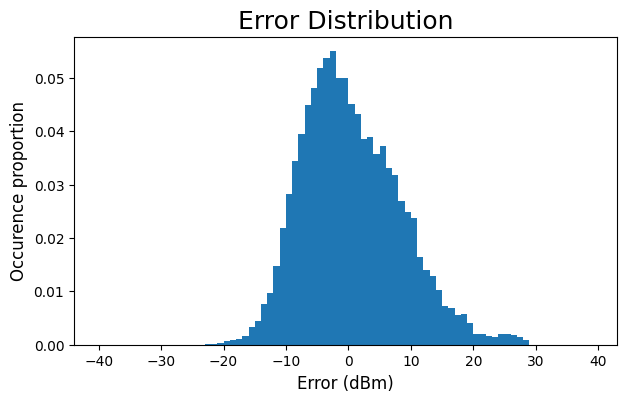

In [65]:
power = 3 # adjustable

calib = np.polyfit(real_means, r_mean, power)
for idx, i in enumerate(calib):
    print(f'gamma_{power-idx} = {i}')
mask = (r>=-80) & (r<-40)
show_err(r[mask], np.polyval(calib, np.polyval(model, np.log(d)[mask])))

In [66]:
# test with real data
for power in range(1, 10):
    calib = np.polyfit(real_means, r_mean, power)
    mask = (r>=-80) & (r<-40)
    print(f'Power {power} ste: {np.sqrt(((np.polyval(calib, np.polyval(model, np.log(d)[mask])) - r[mask])**2).mean()):.3f} dBm')

Power 1 ste: 7.992 dBm
Power 2 ste: 7.996 dBm
Power 3 ste: 7.953 dBm
Power 4 ste: 7.956 dBm
Power 5 ste: 7.958 dBm
Power 6 ste: 7.956 dBm
Power 7 ste: 7.963 dBm
Power 8 ste: 7.963 dBm
Power 9 ste: 7.961 dBm
